In [1]:
import copy
import torch.nn.functional as F
import torch.nn as nn
import torch
import numpy as np
import pandas as pd
import wandb
import time
import os

from training_utils.file_utils import (open_json, write_json, save_submission,
                                       log_whole_dataset_training, log_kfold_training, log_learning_curve)
from training_utils.models import SimpleNN
from training_utils.model_utils import *
from training_utils.training import train_model, k_fold_training


In [2]:
config = open_json("simple_nn_config.json")
DIR_PATH = config["dataset_dir"]
features_dict = open_json(f"{DIR_PATH}/features.json")
features, features_infos = compute_feature_list(config, features_dict)

LOG_NAME = "SimpleNN"

SIMPLE_TRAIN = True
WANDB_SWEEP = False
COMPUTE_LEARNING_CURVE = False
COMPUTE_FEATURE_IMPORTANCE = False
TRAIN_WHOLE_DATASET = False
COMPUTE_SUBMISSION = False

WANDB_SWEEP_ID = None

In [3]:
if torch.cuda.is_available() and config["use_cuda"]:
    device = torch.device("cuda")
else:
    device = torch.device("cpu")

print(device)


cpu


## Wandb 
setup for hyper parameters optimization

In [4]:
if WANDB_SWEEP:
    os.environ["WANDB_SILENT"] = "true"
    sweep_config = open_json("wandb_sweep_config.json")
    if WANDB_SWEEP_ID is None:
        sweep_id = wandb.sweep(sweep_config, project="test")
        print(f"set up new sweep {sweep_id=}")
    else:
        sweep_id = WANDB_SWEEP_ID
        print(f"using given {sweep_id=}")


In [5]:
def load_dataset(config):
    df = pd.read_csv(f"{DIR_PATH}/{config['dataset_name']}.csv")

    for feature in features:
        # remove line with nan values for selected features
        df = df[~(df[feature].isna())]

    # remove bad uniprot
    df = df[~(df["uniprot"].isin(config["bad_uniprot"]))]

    # apply max protein length
    df = df[df.length.le(config["max_protein_length"])]

    print(f"training on {len(df)} data")
    return df


## Wandb Sweep

In [6]:
if WANDB_SWEEP:
    global_config = config.copy()
    main_df = load_dataset(global_config)
    def run():
        # add protein_index to the dataset and get ksplit:
        df, ksplit = split_dataset(main_df, global_config)
        training_results, _, _ = k_fold_training(
            df, ksplit, global_config, features, 
            features_infos, device, wandb_active=True)
    try:
        wandb.agent(sweep_id, run)
        wandb.finish()
    except Exception as e:
        print(f"Exception: {e}")
        wandb.finish()


## Simple train


training on 5866 data
type(all_training_results)=<class 'dict'>


100%|██████████| 5/5 [00:31<00:00,  6.26s/it]


type(all_training_results)=<class 'dict'>
type(all_training_results)=<class 'dict'>
logged training in ./outputs/SimpleNN_2


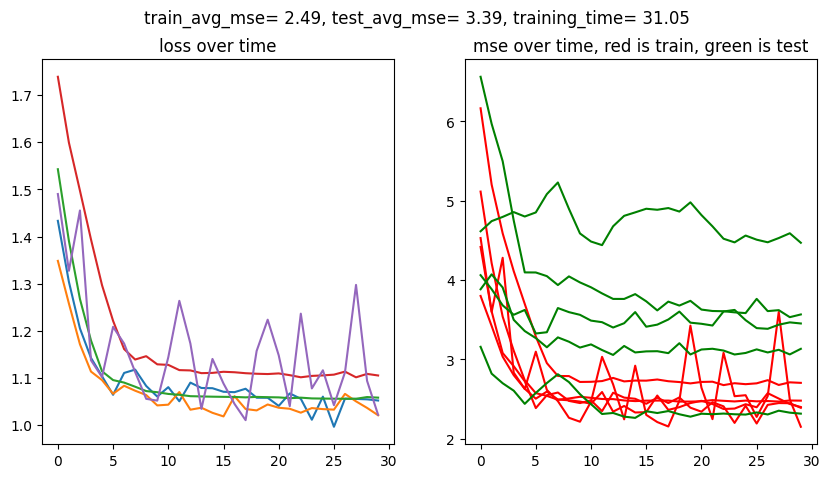

In [7]:
if SIMPLE_TRAIN:
    df = load_dataset(config)

    all_training_results = {"simple_train": [],
                            "total_training_time": 0}
    print(f"{type(all_training_results)=}")

    # add protein_index to the dataset and get ksplit:
    df, ksplit = split_dataset(df, config)
    training_results, _, _ = k_fold_training(
        df, ksplit, config, features, features_infos, device)

    # add training results to all the other ones
    all_training_results["simple_train"] = training_results
    print(f"{type(all_training_results)=}")
    # compute avg_mse and time
    train_mse = sum(x["train_mse"]
                    for x in training_results)/config["kfold"]
    test_mse = sum(x["test_mse"]
                   for x in training_results)/config["kfold"]
    training_time = sum(x["time"] for x in training_results)

    # save results to output
    model = SimpleNN(
        len(features_infos["direct_features"]), config)
    model_structure = str(model).replace('(', '').replace(')', '').split('\n')
    dir_path = log_kfold_training(
        LOG_NAME, all_training_results, config, features, model_structure)
    print(f"{type(all_training_results)=}")
    print(f"logged training in {dir_path}")


## Find worst samples


In [8]:
if SIMPLE_TRAIN:
    WORST_SAMPLES_DIFF_THRESHOLD = 10
    worst_of_the_worst = []
    print(f"{type(all_training_results)=}")
    # WORST_SAMPLES_DIFF_THRESHOLD = 1
    for res in all_training_results.get("simple_train"):
        worst_samples = res.get("worst_samples")
        worst_of_the_worst += [record for record in worst_samples if record["diff"]
                               > WORST_SAMPLES_DIFF_THRESHOLD]

    print(len(worst_of_the_worst))
    write_json("worst_samples.json", worst_of_the_worst)


type(all_training_results)=<class 'dict'>
0


## Learning Curve


In [9]:
if COMPUTE_LEARNING_CURVE:
    df = load_dataset(config)
    # plot the learning curve of the model
    # ie. the avg mse when df has 10, 100, 1000 elements
    # len(df) = 5k
    num_rows = [100, 1000, 3000, len(df)]
    all_training_results = {"training_by_num_rows": [],
                            "learning_curve": {"num_rows": num_rows,
                                               "train_mse": [],
                                               "test_mse": []
                                               },
                            "total_training_time": 0
                            }

    t0 = time.time()
    for n in num_rows:
        print(f"training on {n} rows from the dataset")
        df_n_rows = df.sample(n)
        # add protein_index to the dataset and get ksplit:
        df_n_rows, ksplit = split_dataset(df_n_rows, config)
        training_results, _, _ = k_fold_training(
            df_n_rows, ksplit, config, features, device)

        # add training results to all the other ones
        all_training_results["training_by_num_rows"].append(training_results)
        # compute avg_mse and time
        train_mse = sum(x["train_mse"]
                        for x in training_results)/config["kfold"]
        test_mse = sum(x["test_mse"]
                       for x in training_results)/config["kfold"]
        training_time = sum(x["time"] for x in training_results)

        # update result variables
        all_training_results["total_training_time"] += training_time
        all_training_results["learning_curve"]["train_mse"].append(train_mse)
        all_training_results["learning_curve"]["test_mse"].append(test_mse)

    total_time = time.time()-t0
    print(f"total_training_time= {all_training_results['total_training_time']:.2f}, {total_time= :.2f}, \
        training_time: {(all_training_results['total_training_time']/total_time)*100:.2f}% of total time")


In [10]:
if COMPUTE_LEARNING_CURVE:
    # save results to output
    model = SimpleNN(
        len(features_infos["direct_features"]), config["model_config"])
    model_structure = str(model).replace('(', '').replace(')', '').split('\n')
    dir_path = log_kfold_training(
        LOG_NAME, all_training_results, config, features, model_structure)
    print(f"logged training in {dir_path}")


## Feature Importance


In [11]:
if COMPUTE_FEATURE_IMPORTANCE:
    # all_training_results[feature1]: result obtained when df[feature1] = random
    all_training_results = {}

    df = load_dataset(config)

    # 1. we train k-fold models using all features:
    df, ksplit = split_dataset(df, config)
    ksplit_list = list(ksplit)
    training_results, model_list, scaler_list = k_fold_training(
        df, iter(ksplit_list), config, features, device, keep_models=True)

    # compute mse (with no feature randomized)
    none_random_train_mse = sum(x['train_mse']
                                for x in training_results)/config['k-fold']
    none_random_test_mse = sum(x['test_mse']
                               for x in training_results)/config['k-fold']
    all_training_results["none_randomized"] = {
        "train_mse": none_random_train_mse, "test_mse": none_random_test_mse}

    # 2. for each feature we take the df, randomize the feature column, then compute the new mse score with each model
    for feature in features:
        # create a copy of the dataset with the feature column being random
        df_random = copy.deepcopy(df)
        df_random[feature] = np.random.randint(-1000, 1000, df_random.shape[0])
        training_results = []

        # evaluate all model on this new dataset
        ksplit = iter(ksplit_list)
        for k in range(config["kfold"]):
            # get the same ksplit as during training
            train, test = next(ksplit)
            model = model_list[k]  # model result from the training
            dataset_train_scaler = scaler_list[k]  # scaler from training

            # we load the data for evaluation
            df_train = df_random[df_random["protein_index"].isin(train)]
            df_test = df_random[df_random["protein_index"].isin(test)]
            X_train, y_train = prepare_eval_data(
                df_train, config, features, dataset_train_scaler)
            X_test, y_test = prepare_eval_data(
                df_test, config, features, dataset_train_scaler)

            # Evaluate this model:
            model.eval()
            with torch.set_grad_enabled(False):
                train_mse = evaluate_model(X_train, y_train, model, device)
                test_mse = evaluate_model(X_test, y_test, model, device)
                # print(f"MSE obtained for k-fold {k}: {mse}")
                results = {
                    "train_mse": train_mse,
                    "test_mse": test_mse
                }
                training_results.append(results)

        # compute avg_mse
        train_mse = sum(x['train_mse']
                        for x in training_results)/config['k-fold']
        test_mse = sum(x['test_mse']
                       for x in training_results)/config['k-fold']
        # add training results to all the other ones
        all_training_results[feature] = {
            "train_mse": train_mse, "test_mse": test_mse,
            "delta_train_mse": train_mse-none_random_train_mse,
            "delta_test_mse": test_mse-none_random_test_mse,
        }

    # rank results
    ranked_delta_test_mse = [[x, all_training_results[x].get(
        "delta_test_mse", 0)] for x in all_training_results.keys()]
    ranked_delta_test_mse.sort(key=lambda x: x[1], reverse=True)
    ranked_delta_test_mse = {x[0]: x[1] for x in ranked_delta_test_mse}
    write_json(f"./outputs/{LOG_NAME}_feature_importance.json",
               {"ranked_delta_test_mse": ranked_delta_test_mse,
                "all_training_results": all_training_results})


In [12]:
# stop run all
assert False


AssertionError: 

# Predicting on submission


In [ ]:
def whole_dataset_training(df, config, features, device):
    """
    This function is to be sure to use all available data for submission
    This end up seeing the test dataset from kaggle as the test set, without a cv split
    This is not best practice for generalisation, 
    but we are trying to get the highest LB score afterall...
    """

    training_results = []

    # we load the data for training
    dataset_train = prepare_train_data(df, config, features)
    trainloader = torch.utils.data.DataLoader(dataset_train,
                                              batch_size=config["batch_size"],
                                              shuffle=False,
                                              num_workers=config["num_workers"])

    # we load the data for evaluation
    X_train, y_train = prepare_eval_data(
        df, config, features, dataset_train.scaler)

    # Initialize a new Novozymes Model
    model = SimpleNN(
        len(features_infos["direct_features"]), config["model_config"])
    model.to(torch.double)
    model.to(device)

    # Define the loss function and optimizer
    loss_function = nn.L1Loss()
    optimizer = torch.optim.Adam(model.parameters(), lr=1e-4)

    # Train model:
    model, loss_over_time, mse_over_time, _ = train_model(
        model, config, optimizer, loss_function, trainloader, device)

    # Evaluate this model:
    model.eval()
    with torch.set_grad_enabled(False):
        train_mse = evaluate_model(X_train, y_train, model, device)
        # print(f"MSE obtained for k-fold {k}: {mse}")
        results = {
            "loss_over_time": loss_over_time,
            "mse_over_time": mse_over_time,
            "train_mse": train_mse
        }

    # Process is complete.

    return model, results, dataset_train.scaler


In [ ]:
if TRAIN_WHOLE_DATASET:
    df = pd.read_csv(f"{DIR_PATH}/{config['dataset_name']}.csv")
    model, results, train_scaler = whole_dataset_training(
        df, config, features, device)

    # save results to output
    model_structure = str(model).replace('(', '').replace(')', '').split('\n')
    dir_path = log_whole_dataset_training(LOG_NAME+"_whole_dataset", results,
                                          config, features, model_structure)
    print(f"logged training in {dir_path}")


In [ ]:
if TRAIN_WHOLE_DATASET and COMPUTE_SUBMISSION:
    df_test = pd.read_csv(f"{DIR_PATH}/processed_test.csv")
    X_test = df_test[features]
    X_test = train_scaler.transform(X_test)
    X_test = torch.from_numpy(X_test)
    X_test = X_test.to(device)
    y_test = model(X_test)
    submission = pd.DataFrame(columns=["seq_id", "tm"])
    submission["seq_id"] = df_test["seq_id"]
    submission["tm"] = y_test.detach().numpy() * -1
    print(submission.head())
    save_path = save_submission(submission, LOG_NAME)
    print(f"{save_path=}")
